# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 970988852
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 0.001,
    "warmup_factor": 5,
    'scheduler': 'cosine_schedule_with_warmup',
    "lr_end": 2e-6,
    "power": 0.6,
    "freeze_from_steps": -1,
    'to_freeze_count': 0,
    "seed": seed,
    "num_epoch": 100
}

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model = model.to(device)
# set_pretrained_model_dropout(model.transformer.h, 0.05)

Loaded empty model


# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragonfly!

My name is Darryl Dore. I'm a dragonfly!

Darryl, my name is Dore. I'm a dragonfly!

In my dreams, I'm a dragonfly!

I'm a dragonfly!

My name is Darryl Dore. I'm a dragonfly!

Darryl, my name is Dore. I'm a dragonfly!

In my dreams, I'm a dragonfly!

I'm a dragonfly!

My name is Darryl


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for i, item in enumerate(dataset['train']):
    print(tokenizer.decode(item['input_ids']))
    print("-" * 10)
    if i > 10:
        break

print("RP review!")
to_see_rp = [
    'c "Fight ',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2123 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors


<p><msg>c "Me too."<p><msg>c "There's still plenty left over. What are we going to do with it all?"<d><scn>black<msg>An "We can just leave it here. Hey, maybe the old farmer will help himself to it."<p><msg>c "Won't this attract predators or something?"<d><scn>black<msg>An "So what? They need to eat, too."<p><msg>c "Me too."<p><msg>c "There's still plenty left over. What
----------
 are we going to do with it all?"<d><scn>black<msg>An "We can just leave it here. Hey, maybe the old farmer will help himself to it."<p><msg>c "Won't this attract predators or something?"<d><scn>black<msg>An "So what? They need to eat, too."<|endoftext|><p><msg>c "Sure."<d><scn>loremapt<msg>Lo "Honestly, I can't believe you agreed to do this again."<p><msg>c "It's my pleasure."<
----------
p><msg>c "Sure."<d><scn>loremapt<msg>Lo "Honestly, I can't believe you agreed to do this again."<p><msg>c "It's my pleasure."<|endoftext|><p><msg>c "Actually, I find it worrisome that the chief of police prefers to get dru

Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2126 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors


c "Lorem, you asked me about breath weapons last time, but I don't think you ever told me if you had one."<d><scn>loremapt<msg>Ip "Probably because it isn't worth mentioning."<d><scn>loremapt<msg>Lo "It may only be a very small flame, but it can get very hot."<p><msg>c "What do you think of Lorem?"<d><scn>loremapt<msg>Lo "I think he's funny."<|endoftext|><p><msg>c "Still in the bar
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

Step,Training Loss
54,3.177500
108,2.443500
162,2.014800
216,1.808600
270,1.684200
324,1.584700
378,1.478000
432,1.397700
486,1.310800
540,1.242500


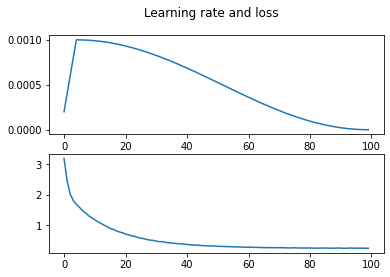

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

In [11]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]

for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp)}')
    print(f'[sampled] {rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
[sampled] Visit Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
[sampled] Meet with Lorem -> loremapt<msg>Lo "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
----------
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
[sampled] Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Fight Maverick -> o2<msg>Mv "Hey [player_name]!"<|endoftext|>
[sampled] Fight Maverick -> beach<msg>m "Maverick started running toward the edge of the sea, but as he did not move, I could see him only too rumply at a certain angle. Then, he sunk, his sunken face barely visible through the lenses I took in account for his bloodline that

In [12]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "Fine [player_name]!"<|endoftext|>
Reply [sampled]: park2<msg>Ry "Do you think I care?"<p><msg>c "Maybe."<d><scn>park2<msg>Ry "Well, hopefully you'll find that x. You can answer "I'm not sure if it's my picture that's up so many months worth of myself right now."<d><scn>park2<msg>Ry
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think he's cute."<|endoftext|>
Reply [sampled]: park2<msg>Ry "I think he's ugly."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: np2x<msg>Ad "It's a shared room with a Mouflon in it. You can make do with what I have available at the facility."<d><scn>np2x<msg>Ad "I think I can find the reference I was going to make. Maybe I can help you with that."<|endoftext|>
Reply [sampled]: np2x<msg>Ad "It's a shared community map that we have on our website. You'll just have to hand me a paper."<p><msg>c "I'll say. You create your own opinions of people based on their comments and said 